In [ ]:
# Read readme.md from github
from google.colab import drive
drive.mount('/gdrive')
%cd "/gdrive/My Drive/Challenge_1/"

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/My Drive/Challenge_1


## Import Python packages

In [ ]:
# Fix randomness and hide warnings
seed = 42

import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
os.environ["PYTHONHASHSEED"] = str(seed)
os.environ["MPLCONFIGDIR"] = os.getcwd() + "/configs/"

import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=Warning)

import numpy as np

np.random.seed(seed)

import logging

import random

random.seed(seed)

# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

# Import other libraries
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    confusion_matrix,
)
import seaborn as sns

2.14.0


In [ ]:
from tensorflow.keras.applications import EfficientNetB0

In [ ]:
IMG_SIZE = 224

## Import dataset

In [ ]:
dataset = np.load('new_dataset.npz', allow_pickle=True) #If you are running it using Colab
images = dataset['data']
labels = dataset['labels']

In [ ]:
# Extract classes separately
healthy_labels = np.where(labels == "healthy")[0]
unhealthy_labels = np.where(labels == "unhealthy")[0]

healthy_images = images[healthy_labels]
unhealthy_images = images[unhealthy_labels]

### Split dataset

In [ ]:
X = np.concatenate([healthy_images, unhealthy_images], axis=0)
y = np.concatenate([np.zeros(len(healthy_images)), np.ones(len(unhealthy_images))], axis=0)

In [ ]:
# Split data into train_val and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, random_state=seed, test_size=0.05, stratify=y
)

# Further split train_val into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val,
    y_train_val,
    random_state=seed,
    test_size=0.15,
    stratify=y_train_val,
)

# Print shapes of the datasets
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (3659, 96, 96, 3), y_train shape: (3659,)
X_val shape: (646, 96, 96, 3), y_val shape: (646,)
X_test shape: (227, 96, 96, 3), y_test shape: (227,)


### Preproces input - EfficientNet

In [ ]:
X_train.shape

(3659, 96, 96, 3)

In [ ]:
def proc_input(X_input):
    X_input = tfkl.Resizing(IMG_SIZE, IMG_SIZE)(X_input)
    X_input = tf.cast(X_input, tf.float32)
    X_input = tf.keras.applications.efficientnet.preprocess_input(X_input)
    return X_input

X_train = proc_input(X_train)
X_val = proc_input(X_val)
# X_test = proc_input(X_test)  ## See last function


### Data balancing

In [ ]:
def populate_dataset(originalDataset: np.ndarray, augmentMethodDict: dict, wantedSize:int) -> np.ndarray:
  # Calculate the sum of the values in the dictionary,
  total_prob = np.sum(list(augmentMethodDict.values()))

  # Check if the sum is not equal to 1 (with some tolerance for floating-point precision)
  if not np.isclose(total_prob, 1.0):
      # Normalize the values in the dictionary to make the sum equal to 1
      augmentMethodDict = {key: value / total_prob for key, value in augmentMethodDict.items()}

  print(augmentMethodDict)

  diff = wantedSize - len(originalDataset)

  for AugFunct, percentage in augmentMethodDict.items():
    number_of_images = int(percentage * diff)
    random_indices = np.random.choice(len(originalDataset), number_of_images, replace=False)
    random_elements = originalDataset[random_indices]
    augmented_images = AugFunct(random_elements)
    originalDataset = np.concatenate((originalDataset, augmented_images))

  if len(originalDataset) < wantedSize:
    diff = wantedSize - len(originalDataset)
    random_indices = np.random.choice(len(originalDataset), diff, replace=False)
    random_elements = originalDataset[random_indices]
    originalDataset = np.concatenate((originalDataset, random_elements))

  if len(originalDataset) > wantedSize:
    originalDataset = originalDataset[:wantedSize]

  return originalDataset

In [ ]:
flip = tf.keras.Sequential([tfkl.RandomFlip("horizontal")])

translation = tf.keras.Sequential([tfkl.RandomTranslation(0.2, 0.2)])

rotation = tf.keras.Sequential([tfkl.RandomRotation(0.2)])

augmentMethodDict = {
    flip: 0.3,
    translation: 0.3,
    rotation: 0.4,
}

In [ ]:
X_train = X_train.numpy()
# Seperate the healthy and unhealthy images
healthy_images = X_train[np.where(y_train == 0)[0]]
unhealthy_images = X_train[np.where(y_train == 1)[0]]
print(healthy_images.shape)
print(unhealthy_images.shape)

(2342, 224, 224, 3)
(1317, 224, 224, 3)


In [ ]:
#healthy_images = tf.convert_to_tensor(populate_dataset(healthy_images, augmentMethodDict, 1000))
unhealthy_images = tf.convert_to_tensor(populate_dataset(unhealthy_images, augmentMethodDict, len(healthy_images)))
print(healthy_images.shape)
print(unhealthy_images.shape)
# Concatenate the healthy and unhealthy images
X_train = tf.concat([healthy_images, unhealthy_images], axis=0)

# Create the labels healthy and unhealthy
healthy_labels = tf.convert_to_tensor([0] * len(healthy_images))
unhealthy_labels = tf.convert_to_tensor([1] * len(unhealthy_images))
y_train = tf.concat([healthy_labels, unhealthy_labels], axis=0)

# Shuffle the data
# Shuffle the data wich is an np.array
X_train, y_train = tf.random.shuffle(X_train, seed=seed), tf.random.shuffle(y_train, seed=seed)

{<keras.src.engine.sequential.Sequential object at 0x7b74ef8ca3b0>: 0.3, <keras.src.engine.sequential.Sequential object at 0x7b74ef8cb400>: 0.3, <keras.src.engine.sequential.Sequential object at 0x7b74ef8c9900>: 0.4}
(2342, 224, 224, 3)
(2342, 224, 224, 3)


In [ ]:
# Print shapes of the datasets
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (4684, 224, 224, 3), y_train shape: (4684,)
X_val shape: (646, 224, 224, 3), y_val shape: (646,)
X_test shape: (227, 96, 96, 3), y_test shape: (227,)


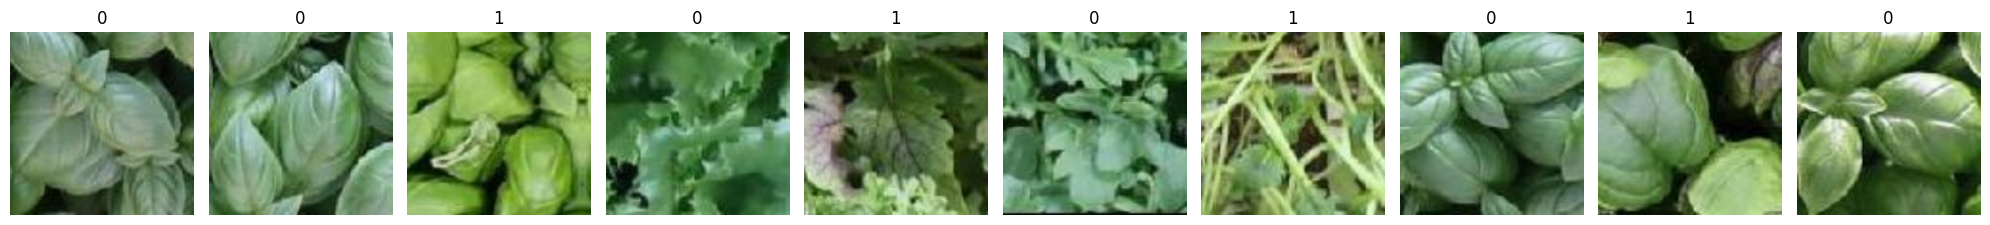

In [ ]:
num_img = 10

random_indices = np.random.permutation(len(X_train))
images = X_train.numpy()[random_indices[:num_img]].copy()
labels = y_train.numpy()[random_indices[:num_img]].copy()

images = images.astype(np.float32)

fig, axes = plt.subplots(1, num_img, figsize=(20, 9))
axes = axes.flatten()
for i in range(num_img):
    ax = axes[i]
    ax.imshow(np.clip(images[i], 0, 255).astype(np.uint8))
    ax.axis("off")
    ax.set_title(labels[i])
plt.tight_layout()
plt.show()


### Training input parameters

In [ ]:
# Define input shape, output shape, batch size, and number of epochs
input_shape = X_train.shape[1:]
output_shape = 1
batch_size = 80
epochs = 50

# Print input shape, batch size, and number of epochs
print(
    f"Input Shape: {input_shape}, Output Shape: {output_shape}, Batch Size: {batch_size}, Epochs: {epochs}"
)

Input Shape: (224, 224, 3), Output Shape: 1, Batch Size: 80, Epochs: 50


### Callbacks

In [ ]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy',
                             factor=np.sqrt(.1),
                             patience=6,
                             verbose=1,
                             mode='auto',
                             min_delta=.0001,
                             cooldown=0,
                             min_lr=0.0000001)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=8)

calbacks = [reduce_lr, early_stopping]

### Data augmentations

In [ ]:
img_augmentation = tfk.Sequential(
    [
        tfk.layers.RandomRotation(factor=0.15),
        tfk.layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
        tfk.layers.RandomFlip(),
        tfk.layers.RandomContrast(factor=0.1),
        tfk.layers.RandomZoom(height_factor=0.1, width_factor=0.1),
    ],
    name="img_augmentation",
)

## Model 1

In [ ]:
def build_model(num_classes):
    inputs = tfk.layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = img_augmentation(inputs)
    model = EfficientNetB0(include_top=False, input_tensor=x, weights="imagenet")

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = tfk.layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = tfk.layers.BatchNormalization()(x)

    x = tfk.layers.Dropout(0.3, name="top1_dropout")(x)

    outputs = tfk.layers.Dense(num_classes, activation="sigmoid", name="pred")(x)

    # Compile
    model = tf.keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = tf.keras.optimizers.Nadam(learning_rate=1e-3)

    loss = tf.keras.losses.BinaryCrossentropy()
    metrics = ["accuracy"]

    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    return model

In [ ]:
model_model1 = build_model(num_classes=1)

epochs = 50  # @param {type: "slider", min:8, max:80}
model1 = model_model1.fit(
    X_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val),
    callbacks=calbacks,
    verbose=1,
).history

Epoch 1/50
59/59 [==============================] - 23s 233ms/step - loss: 0.7383 - accuracy: 0.6038 - val_loss: 0.5773 - val_accuracy: 0.7632 - lr: 0.0010
Epoch 2/50
59/59 [==============================] - 11s 193ms/step - loss: 0.5488 - accuracy: 0.7323 - val_loss: 0.5322 - val_accuracy: 0.7616 - lr: 0.0010
Epoch 3/50
59/59 [==============================] - 12s 197ms/step - loss: 0.5374 - accuracy: 0.7464 - val_loss: 0.4920 - val_accuracy: 0.7771 - lr: 0.0010
Epoch 4/50
59/59 [==============================] - 12s 201ms/step - loss: 0.4885 - accuracy: 0.7741 - val_loss: 0.4442 - val_accuracy: 0.8003 - lr: 0.0010
Epoch 5/50
59/59 [==============================] - 13s 219ms/step - loss: 0.4649 - accuracy: 0.7797 - val_loss: 0.4294 - val_accuracy: 0.7972 - lr: 0.0010
Epoch 6/50
59/59 [==============================] - 13s 216ms/step - loss: 0.4553 - accuracy: 0.7882 - val_loss: 0.4105 - val_accuracy: 0.8220 - lr: 0.0010
Epoch 7/50
59/59 [==============================] - 13s 222ms/st

In [ ]:
def unfreeze_model(model):
    # We unfreeze the top 20 layers while leaving BatchNorm layers frozen
    for layer in model.layers[-25:]:
        if not isinstance(layer, tfk.layers.BatchNormalization):
            layer.trainable = True

    learning_rate = 1e-4
    # Create AdamW optimizer
    optimizer = tf.keras.optimizers.Nadam(learning_rate=learning_rate)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )

In [ ]:
unfreeze_model(model_model1)

epochs = 50  # @param {type: "slider", min:8, max:80}
model1 = model_model1.fit(
    X_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val),
    callbacks=calbacks,
    verbose=1,
).history

Epoch 1/50
59/59 [==============================] - 70s 1s/step - loss: 0.0000e+00 - accuracy: 0.8053 - val_loss: 0.0000e+00 - val_accuracy: 0.8096 - lr: 1.0000e-04
Epoch 2/50
59/59 [==============================] - 12s 206ms/step - loss: 0.0000e+00 - accuracy: 0.7953 - val_loss: 0.0000e+00 - val_accuracy: 0.7941 - lr: 1.0000e-04
Epoch 3/50
59/59 [==============================] - 12s 211ms/step - loss: 0.0000e+00 - accuracy: 0.7908 - val_loss: 0.0000e+00 - val_accuracy: 0.7988 - lr: 1.0000e-04
Epoch 4/50
59/59 [==============================] - 13s 213ms/step - loss: 0.0000e+00 - accuracy: 0.8064 - val_loss: 0.0000e+00 - val_accuracy: 0.8204 - lr: 1.0000e-04
Epoch 5/50
59/59 [==============================] - 14s 236ms/step - loss: 0.0000e+00 - accuracy: 0.8228 - val_loss: 0.0000e+00 - val_accuracy: 0.8251 - lr: 1.0000e-04
Epoch 6/50
59/59 [==============================] - 14s 232ms/step - loss: 0.0000e+00 - accuracy: 0.8258 - val_loss: 0.0000e+00 - val_accuracy: 0.8220 - lr: 1.0000

## Model 2

In [ ]:
def build_model(num_classes):
    inputs = tfk.layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = img_augmentation(inputs)
    model = EfficientNetB0(include_top=False, input_tensor=x, weights="imagenet")

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = tfk.layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = tfk.layers.BatchNormalization()(x)

    x = tfk.layers.Dropout(0.3, name="top1_dropout")(x)
    x = tfk.layers.Dense(10, activation="relu")(x)
    x = tfk.layers.BatchNormalization()(x)

    outputs = tfk.layers.Dense(num_classes, activation="sigmoid", name="pred")(x)

    # Compile
    model = tf.keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = tf.keras.optimizers.Nadam(learning_rate=1e-3)

    loss = tf.keras.losses.BinaryCrossentropy()
    metrics = ["accuracy"]

    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    return model

In [ ]:
model_model2 = build_model(num_classes=1)

epochs = 50  # @param {type: "slider", min:8, max:80}
model2 = model_model2.fit(
    X_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val),
    callbacks=calbacks,
    verbose=1,
).history

Epoch 1/50
59/59 [==============================] - 25s 257ms/step - loss: 0.6330 - accuracy: 0.6573 - val_loss: 0.5182 - val_accuracy: 0.8003 - lr: 0.0010
Epoch 2/50
59/59 [==============================] - 12s 202ms/step - loss: 0.4931 - accuracy: 0.7617 - val_loss: 0.4721 - val_accuracy: 0.7755 - lr: 0.0010
Epoch 3/50
59/59 [==============================] - 12s 200ms/step - loss: 0.4486 - accuracy: 0.7871 - val_loss: 0.4358 - val_accuracy: 0.7926 - lr: 0.0010
Epoch 4/50
59/59 [==============================] - 12s 206ms/step - loss: 0.4319 - accuracy: 0.8010 - val_loss: 0.4140 - val_accuracy: 0.8096 - lr: 0.0010
Epoch 5/50
59/59 [==============================] - 14s 230ms/step - loss: 0.4257 - accuracy: 0.8021 - val_loss: 0.3912 - val_accuracy: 0.8111 - lr: 0.0010
Epoch 6/50
59/59 [==============================] - 13s 225ms/step - loss: 0.3986 - accuracy: 0.8228 - val_loss: 0.3720 - val_accuracy: 0.8235 - lr: 0.0010
Epoch 7/50
59/59 [==============================] - 13s 220ms/st

In [ ]:
def unfreeze_model(model):
    # We unfreeze the top 20 layers while leaving BatchNorm layers frozen
    for layer in model.layers[-25:]:
        if not isinstance(layer, tfk.layers.BatchNormalization):
            layer.trainable = True

    learning_rate = 1e-4
    # Create AdamW optimizer
    optimizer = tf.keras.optimizers.Nadam(learning_rate=learning_rate)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )

In [ ]:
unfreeze_model(model_model2)

epochs = 50  # @param {type: "slider", min:8, max:80}
model2 = model_model2.fit(
    X_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val),
    callbacks=calbacks,
    verbose=1,
).history

Epoch 1/50
59/59 [==============================] - 29s 258ms/step - loss: 0.0000e+00 - accuracy: 0.8367 - val_loss: 0.0000e+00 - val_accuracy: 0.8375 - lr: 1.0000e-04
Epoch 2/50
59/59 [==============================] - 12s 211ms/step - loss: 0.0000e+00 - accuracy: 0.8339 - val_loss: 0.0000e+00 - val_accuracy: 0.8390 - lr: 1.0000e-04
Epoch 3/50
59/59 [==============================] - 13s 214ms/step - loss: 0.0000e+00 - accuracy: 0.8316 - val_loss: 0.0000e+00 - val_accuracy: 0.8313 - lr: 1.0000e-04
Epoch 4/50
59/59 [==============================] - 13s 216ms/step - loss: 0.0000e+00 - accuracy: 0.8360 - val_loss: 0.0000e+00 - val_accuracy: 0.8498 - lr: 1.0000e-04
Epoch 5/50
59/59 [==============================] - 14s 233ms/step - loss: 0.0000e+00 - accuracy: 0.8499 - val_loss: 0.0000e+00 - val_accuracy: 0.8607 - lr: 1.0000e-04
Epoch 6/50
59/59 [==============================] - 12s 209ms/step - loss: 0.0000e+00 - accuracy: 0.8553 - val_loss: 0.0000e+00 - val_accuracy: 0.8545 - lr: 1.0

## Model 3

In [ ]:
def build_model(num_classes):
    inputs = tfk.layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = img_augmentation(inputs)
    model = EfficientNetB0(include_top=False, input_tensor=x, weights="imagenet")

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = tfk.layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = tfk.layers.BatchNormalization()(x)

    x = tfk.layers.Dropout(0.3, name="top1_dropout")(x)
    x = tfk.layers.Dense(20, activation="relu")(x)
    x = tfk.layers.BatchNormalization()(x)
    outputs = tfk.layers.Dense(num_classes, activation="sigmoid", name="pred")(x)

    # Compile
    model = tf.keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = tf.keras.optimizers.Nadam(learning_rate=1e-3)

    loss = tf.keras.losses.BinaryCrossentropy()
    metrics = ["accuracy"]

    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    return model

In [ ]:
model_model3 = build_model(num_classes=1)

epochs = 50  # @param {type: "slider", min:8, max:80}
model3 = model_model3.fit(
    X_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val),
    callbacks=calbacks,
    verbose=1,
).history

Epoch 1/50
59/59 [==============================] - 24s 245ms/step - loss: 0.5847 - accuracy: 0.6909 - val_loss: 0.5512 - val_accuracy: 0.7461 - lr: 0.0010
Epoch 2/50
59/59 [==============================] - 12s 200ms/step - loss: 0.4630 - accuracy: 0.7820 - val_loss: 0.5046 - val_accuracy: 0.7477 - lr: 0.0010
Epoch 3/50
59/59 [==============================] - 12s 204ms/step - loss: 0.4342 - accuracy: 0.8023 - val_loss: 0.4576 - val_accuracy: 0.7786 - lr: 0.0010
Epoch 4/50
59/59 [==============================] - 12s 204ms/step - loss: 0.4258 - accuracy: 0.8032 - val_loss: 0.4284 - val_accuracy: 0.7879 - lr: 0.0010
Epoch 5/50
59/59 [==============================] - 13s 215ms/step - loss: 0.4093 - accuracy: 0.8138 - val_loss: 0.3954 - val_accuracy: 0.8034 - lr: 0.0010
Epoch 6/50
59/59 [==============================] - 14s 238ms/step - loss: 0.3920 - accuracy: 0.8162 - val_loss: 0.3784 - val_accuracy: 0.8204 - lr: 0.0010
Epoch 7/50
59/59 [==============================] - 12s 202ms/st

In [ ]:
def unfreeze_model(model):
    # We unfreeze the top 20 layers while leaving BatchNorm layers frozen
    for layer in model.layers[-25:]:
        if not isinstance(layer, tfk.layers.BatchNormalization):
            layer.trainable = True

    learning_rate = 1e-4
    # Create AdamW optimizer
    optimizer = tf.keras.optimizers.Nadam(learning_rate=learning_rate)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )

In [ ]:
unfreeze_model(model_model3)

epochs = 50  # @param {type: "slider", min:8, max:80}
model4 = model_model3.fit(
    X_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val),
    callbacks=calbacks,
    verbose=1,
).history

Epoch 1/50
59/59 [==============================] - 28s 267ms/step - loss: 0.0000e+00 - accuracy: 0.8527 - val_loss: 0.0000e+00 - val_accuracy: 0.8421 - lr: 1.0000e-04
Epoch 2/50
59/59 [==============================] - 14s 237ms/step - loss: 0.0000e+00 - accuracy: 0.8335 - val_loss: 0.0000e+00 - val_accuracy: 0.8220 - lr: 1.0000e-04
Epoch 3/50
59/59 [==============================] - 13s 214ms/step - loss: 0.0000e+00 - accuracy: 0.8234 - val_loss: 0.0000e+00 - val_accuracy: 0.8282 - lr: 1.0000e-04
Epoch 4/50
59/59 [==============================] - 12s 210ms/step - loss: 0.0000e+00 - accuracy: 0.8237 - val_loss: 0.0000e+00 - val_accuracy: 0.8421 - lr: 1.0000e-04
Epoch 5/50
59/59 [==============================] - 13s 214ms/step - loss: 0.0000e+00 - accuracy: 0.8365 - val_loss: 0.0000e+00 - val_accuracy: 0.8390 - lr: 1.0000e-04
Epoch 6/50
59/59 [==============================] - 13s 215ms/step - loss: 0.0000e+00 - accuracy: 0.8395 - val_loss: 0.0000e+00 - val_accuracy: 0.8437 - lr: 1.0

## Model 4

In [ ]:
def build_model(num_classes):
    inputs = tfk.layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = img_augmentation(inputs)
    model = EfficientNetB0(include_top=False, input_tensor=x, weights="imagenet")

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = tfk.layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = tfk.layers.BatchNormalization()(x)

    x = tfk.layers.Dropout(0.3, name="top_dropout_2")(x)
    x = tfk.layers.Dense(20, activation="relu")(x)
    x = tfk.layers.Dropout(0.3, name="top_dropout_1")(x)
    x = tfk.layers.Dense(10, activation="relu", kernel_initializer=tfk.initializers.HeUniform(seed=seed))(x)
    x = tfk.layers.BatchNormalization()(x)

    outputs = tfk.layers.Dense(num_classes, activation="sigmoid", name="pred", kernel_initializer=tfk.initializers.GlorotUniform(seed=seed))(x)

    # Compile
    model = tf.keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = tf.keras.optimizers.Nadam(learning_rate=1e-3)

    loss = tf.keras.losses.BinaryCrossentropy()
    metrics = ["accuracy"]

    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    return model

In [ ]:
model_model4 = build_model(num_classes=1)

epochs = 50  # @param {type: "slider", min:8, max:80}
model4 = model_model4.fit(
    X_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val),
    callbacks=calbacks,
    verbose=1,
).history

Epoch 1/50
59/59 [==============================] - 26s 256ms/step - loss: 0.7318 - accuracy: 0.6012 - val_loss: 0.5804 - val_accuracy: 0.7090 - lr: 0.0010
Epoch 2/50
59/59 [==============================] - 12s 205ms/step - loss: 0.5489 - accuracy: 0.7272 - val_loss: 0.5249 - val_accuracy: 0.7322 - lr: 0.0010
Epoch 3/50
59/59 [==============================] - 13s 220ms/step - loss: 0.5168 - accuracy: 0.7374 - val_loss: 0.4842 - val_accuracy: 0.7585 - lr: 0.0010
Epoch 4/50
59/59 [==============================] - 12s 209ms/step - loss: 0.4890 - accuracy: 0.7579 - val_loss: 0.4584 - val_accuracy: 0.7740 - lr: 0.0010
Epoch 5/50
59/59 [==============================] - 12s 204ms/step - loss: 0.4573 - accuracy: 0.7897 - val_loss: 0.4265 - val_accuracy: 0.7910 - lr: 0.0010
Epoch 6/50
59/59 [==============================] - 12s 204ms/step - loss: 0.4604 - accuracy: 0.7820 - val_loss: 0.4005 - val_accuracy: 0.8111 - lr: 0.0010
Epoch 7/50
59/59 [==============================] - 13s 220ms/st

In [ ]:
def unfreeze_model(model):
    # We unfreeze the top 20 layers while leaving BatchNorm layers frozen
    for layer in model.layers[-25:]:
        if not isinstance(layer, tfk.layers.BatchNormalization):
            layer.trainable = True

    learning_rate = 1e-4
    # Create AdamW optimizer
    optimizer = tf.keras.optimizers.Nadam(learning_rate=learning_rate)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )

In [ ]:
unfreeze_model(model_model4)

epochs = 60  # @param {type: "slider", min:8, max:80}
model1 = model_model4.fit(
    X_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val),
    callbacks=calbacks,
    verbose=1,
).history

Epoch 1/60
59/59 [==============================] - 25s 239ms/step - loss: 0.0000e+00 - accuracy: 0.8318 - val_loss: 0.0000e+00 - val_accuracy: 0.8437 - lr: 1.0000e-04
Epoch 2/60
59/59 [==============================] - 14s 238ms/step - loss: 0.0000e+00 - accuracy: 0.8339 - val_loss: 0.0000e+00 - val_accuracy: 0.8498 - lr: 1.0000e-04
Epoch 3/60
59/59 [==============================] - 13s 218ms/step - loss: 0.0000e+00 - accuracy: 0.8380 - val_loss: 0.0000e+00 - val_accuracy: 0.8498 - lr: 1.0000e-04
Epoch 4/60
59/59 [==============================] - 13s 217ms/step - loss: 0.0000e+00 - accuracy: 0.8465 - val_loss: 0.0000e+00 - val_accuracy: 0.8607 - lr: 1.0000e-04
Epoch 5/60
59/59 [==============================] - 14s 234ms/step - loss: 0.0000e+00 - accuracy: 0.8525 - val_loss: 0.0000e+00 - val_accuracy: 0.8560 - lr: 1.0000e-04
Epoch 6/60
59/59 [==============================] - 13s 213ms/step - loss: 0.0000e+00 - accuracy: 0.8533 - val_loss: 0.0000e+00 - val_accuracy: 0.8622 - lr: 1.0

## Model 5

In [ ]:
def build_model(num_classes):
    inputs = tfk.layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = img_augmentation(inputs)
    model = EfficientNetB0(include_top=False, input_tensor=x, weights="imagenet")

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = tfk.layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = tfk.layers.BatchNormalization()(x)

    x = tfk.layers.Dropout(0.3, name="top_dropout_2")(x)
    x = tfk.layers.Dense(32, activation="relu")(x)
    x = tfk.layers.Dense(16, activation="relu")(x)
    x = tfk.layers.Dense(8, activation="relu")(x)
    x = tfk.layers.Dropout(0.3, name="top_dropout_1")(x)

    outputs = tfk.layers.Dense(num_classes, activation="sigmoid", name="pred")(x)

    # Compile
    model = tf.keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = tf.keras.optimizers.Nadam(learning_rate=1e-3)

    loss = tf.keras.losses.BinaryCrossentropy()
    metrics = ["accuracy"]

    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    return model

In [ ]:
model_model5 = build_model(num_classes=1)

epochs = 50  # @param {type: "slider", min:8, max:80}
model2 = model_model5.fit(
    X_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val),
    callbacks=calbacks,
    verbose=1,
).history

Epoch 1/50
59/59 [==============================] - 24s 252ms/step - loss: 0.6562 - accuracy: 0.6074 - val_loss: 0.5854 - val_accuracy: 0.7786 - lr: 0.0010
Epoch 2/50
59/59 [==============================] - 13s 229ms/step - loss: 0.5213 - accuracy: 0.7385 - val_loss: 0.4960 - val_accuracy: 0.7895 - lr: 0.0010
Epoch 3/50
59/59 [==============================] - 12s 209ms/step - loss: 0.4815 - accuracy: 0.7711 - val_loss: 0.4692 - val_accuracy: 0.7988 - lr: 0.0010
Epoch 4/50
59/59 [==============================] - 13s 223ms/step - loss: 0.4660 - accuracy: 0.7799 - val_loss: 0.4296 - val_accuracy: 0.8173 - lr: 0.0010
Epoch 5/50
59/59 [==============================] - 12s 198ms/step - loss: 0.4386 - accuracy: 0.8040 - val_loss: 0.4031 - val_accuracy: 0.8266 - lr: 0.0010
Epoch 6/50
59/59 [==============================] - 12s 206ms/step - loss: 0.4305 - accuracy: 0.8072 - val_loss: 0.3798 - val_accuracy: 0.8390 - lr: 0.0010
Epoch 7/50
59/59 [==============================] - 12s 207ms/st

In [ ]:
def unfreeze_model(model):
    # We unfreeze the top 20 layers while leaving BatchNorm layers frozen
    for layer in model.layers[-25:]:
        if not isinstance(layer, tfk.layers.BatchNormalization):
            layer.trainable = True

    learning_rate = 1e-4
    # Create AdamW optimizer
    optimizer = tf.keras.optimizers.Nadam(learning_rate=learning_rate)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )

In [ ]:
unfreeze_model(model_model5)

epochs = 50  # @param {type: "slider", min:8, max:80}
model5 = model_model5.fit(
    X_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val),
    callbacks=calbacks,
    verbose=1,
).history

Epoch 1/50
59/59 [==============================] - 28s 247ms/step - loss: 0.0000e+00 - accuracy: 0.7536 - val_loss: 0.0000e+00 - val_accuracy: 0.7229 - lr: 1.0000e-04
Epoch 2/50
59/59 [==============================] - 14s 243ms/step - loss: 0.0000e+00 - accuracy: 0.6514 - val_loss: 0.0000e+00 - val_accuracy: 0.7430 - lr: 1.0000e-04
Epoch 3/50
59/59 [==============================] - 13s 219ms/step - loss: 0.0000e+00 - accuracy: 0.6307 - val_loss: 0.0000e+00 - val_accuracy: 0.7245 - lr: 1.0000e-04
Epoch 4/50
59/59 [==============================] - 14s 237ms/step - loss: 0.0000e+00 - accuracy: 0.5922 - val_loss: 0.0000e+00 - val_accuracy: 0.7043 - lr: 1.0000e-04
Epoch 5/50
59/59 [==============================] - 13s 215ms/step - loss: 0.0000e+00 - accuracy: 0.5425 - val_loss: 0.0000e+00 - val_accuracy: 0.6687 - lr: 1.0000e-04
Epoch 6/50
59/59 [==============================] - 13s 216ms/step - loss: 0.0000e+00 - accuracy: 0.5179 - val_loss: 0.0000e+00 - val_accuracy: 0.6533 - lr: 1.0

## Comparison of the models

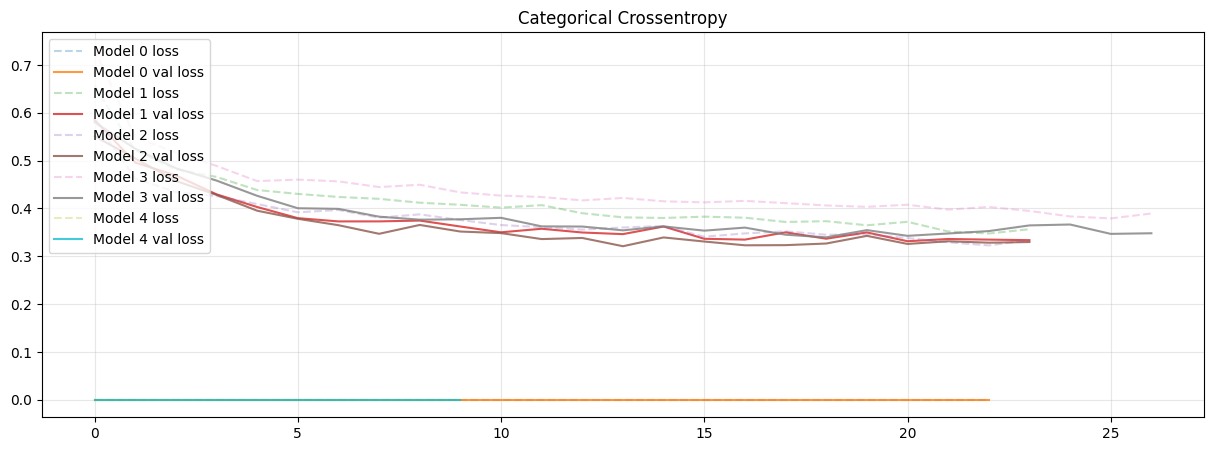

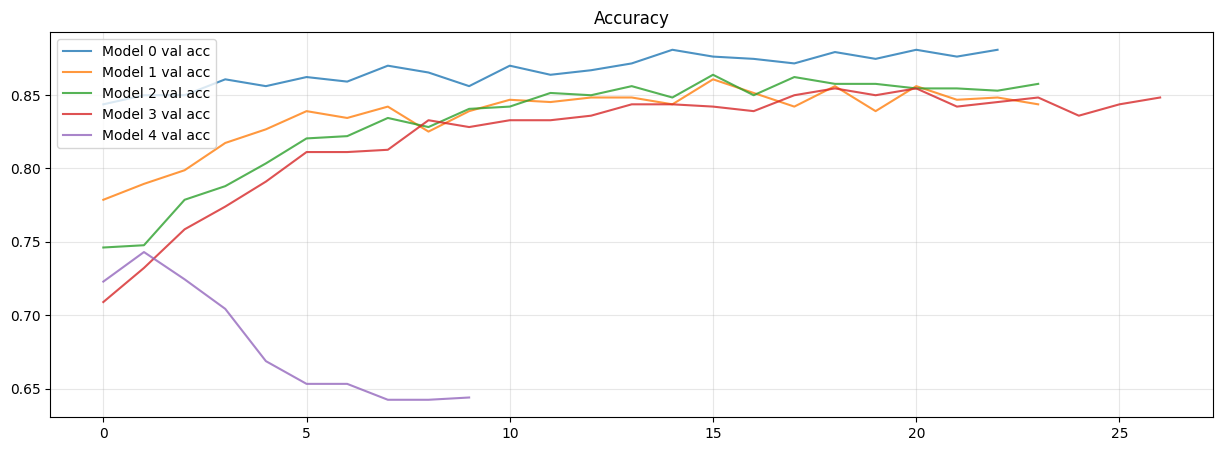

In [ ]:
modelsToPlot = [model1, model2, model3, model4, model5]

plt.figure(figsize=(15, 5))

for i, model in enumerate(modelsToPlot):
    plt.plot(model["loss"], alpha=0.3, label=f"Model {i} loss", linestyle="--")
    plt.plot(model["val_loss"], label=f"Model {i} val loss", alpha=0.8)

plt.legend(loc="upper left")
plt.title("Categorical Crossentropy")
plt.grid(alpha=0.3)
plt.show()

plt.figure(figsize=(15, 5))

for i, model in enumerate(modelsToPlot):
    # plt.plot(model["accuracy"], alpha=0.3, label=f"Model {i} acc", linestyle="--")
    plt.plot(model["val_accuracy"], label=f"Model {i} val acc", alpha=0.8)

plt.legend(loc="upper left")
plt.title("Accuracy")
plt.grid(alpha=0.3)
plt.show()


## Confusion matrix

Accuracy: 0.8811
Precision: 0.9104
Recall: 0.7439
F1: 0.8188


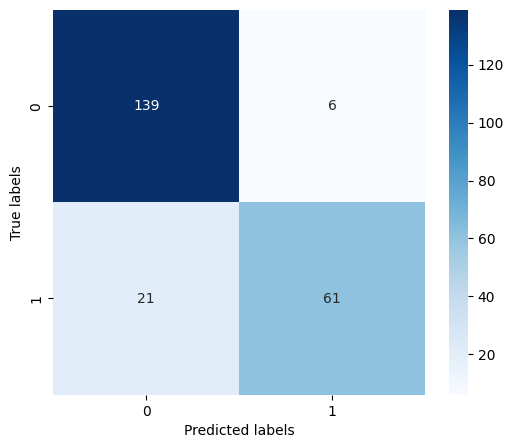

In [ ]:
predictions = model_model2.predict(proc_input(X_test), verbose=0)
# Define your labels (0 and 1 in this case)
labels = [0, 1]

# Assuming 'predictions' is an array of probabilities (sigmoid output)
# If 'predictions' contains probabilities, convert them to binary predictions using a threshold of 0.5
binary_predictions = (predictions > 0.5).astype(int)

# Compute the confusion matrix
cm = confusion_matrix(y_test, binary_predictions)

# Compute classification metrics
accuracy = accuracy_score(y_test, binary_predictions)
precision = precision_score(y_test, binary_predictions)
recall = recall_score(y_test, binary_predictions)
f1 = f1_score(y_test, binary_predictions)

# Display the computed metrics
print('Accuracy:', accuracy.round(4))
print('Precision:', precision.round(4))
print('Recall:', recall.round(4))
print('F1:', f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=labels, yticklabels=labels, cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()


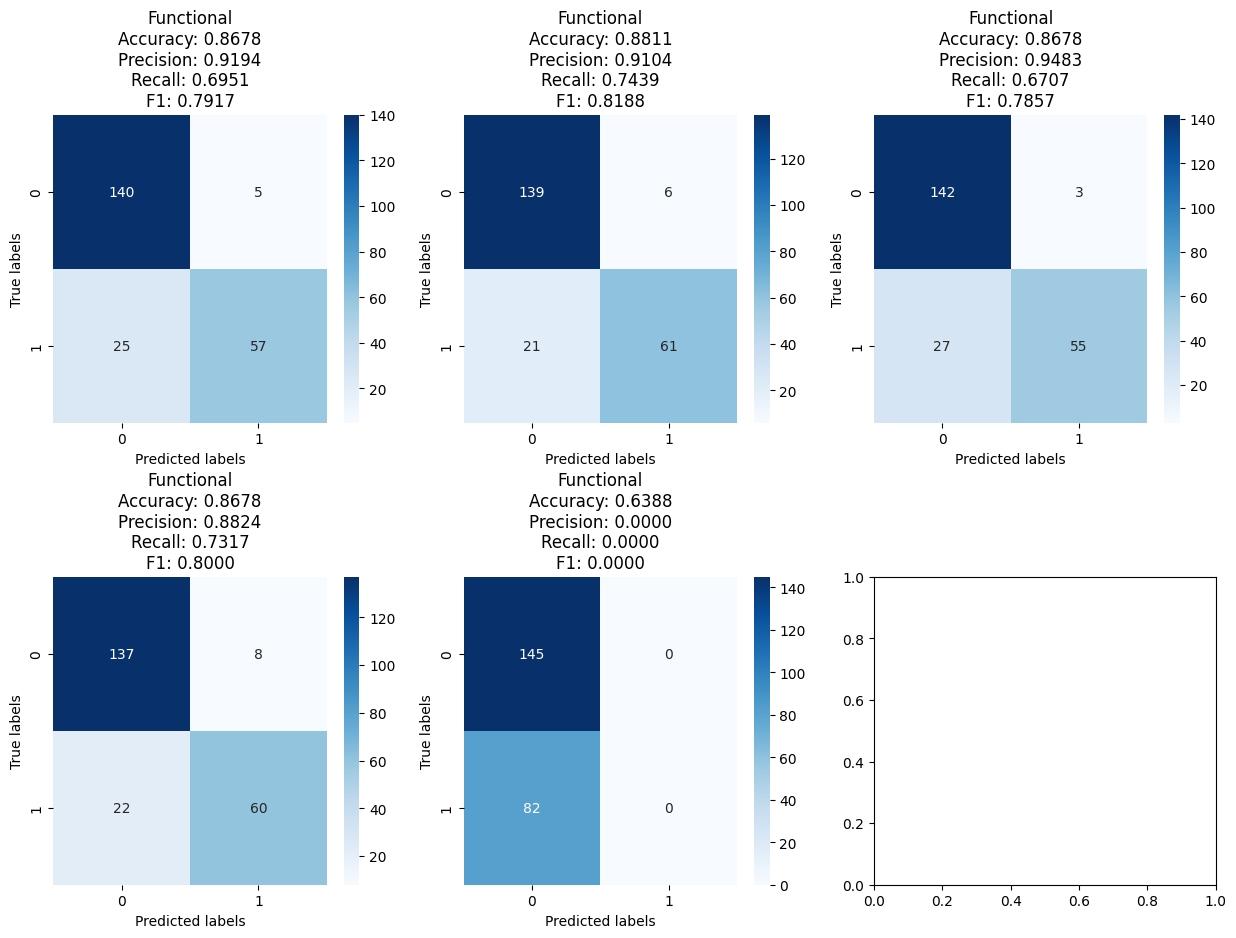

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

modelsToPlot = [model_model1, model_model2, model_model3, model_model4, model_model5]

# Assuming you have X_test and y_test defined
labels = [0, 1]

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.subplots_adjust(hspace=0.5)

for i, model in enumerate(modelsToPlot):
    # Assuming you have defined proc_input function
    predictions = model.predict(proc_input(X_test), verbose=0)

    # Assuming 'predictions' is an array of probabilities (sigmoid output)
    # If 'predictions' contains probabilities, convert them to binary predictions using a threshold of 0.5
    binary_predictions = (predictions > 0.5).astype(int)

    # Compute the confusion matrix
    cm = confusion_matrix(y_test, binary_predictions)

    # Compute classification metrics
    accuracy = accuracy_score(y_test, binary_predictions)
    precision = precision_score(y_test, binary_predictions)
    recall = recall_score(y_test, binary_predictions)
    f1 = f1_score(y_test, binary_predictions)

    # Plot the confusion matrix
    ax = axes.flatten()[i]

    sns.heatmap(cm, annot=True, fmt="d", xticklabels=labels, yticklabels=labels, cmap='Blues', ax=ax)
    ax.set_title(f'{model.__class__.__name__}\nAccuracy: {accuracy:.4f}\nPrecision: {precision:.4f}\nRecall: {recall:.4f}\nF1: {f1:.4f}')
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')

plt.show()
